# Lecture 3-4: SciPy

## Contents

- [Introduction](#Introduction)
- [Root finding](#Rootfinding)
    - [Scalar functions](#root_scalar)
    - [Specifying additional arguments](#additional)
    - [Multidimensinal functions](#root_multi)
- [Optimization](#Optimization)
    - [Optimization of scalar functions](#Optimization-of-scalar-functions)
    - [Optimization of multivariate functions](#Optimization-of-multivariate-functions)
    - [Other Optimization Libraries](#Other-Optimization-Libraries)
- [Statistics](#statistics)
- [Data fitting](#datafitting)
    - [Linear regression](#linearregression)
    - [Non-linear regression](#nonlinearregression)   
- [Interpolation](#Interpolation)

## Introduction

SciPy is a scientific library for Python that builds on NumPy. It contains many numerical algorithms, in particular for optimization and statistics, as well as many linear algebra functionality. The module `scipy.optimize` contains several root finding algorithms, least-squares solvers and various routines for uncontrained, constrained, and global optimization.




In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize

We note that the `scipy.linalg` module has a large overlap with the `numpy.linalg` module. Many functions are the same or have slightly different options. In addition `scipy.linalg` has some additional matrix factorization methods, extended solvers, and matrix creation routines. We don't consider these here.


## Root finding <a name='Rootfinding'></a>

### Scalar functions <a name="root_scalar"></a>

Finding the root of a scalar function can be written mathematically as

$$f(x) = 0, \qquad x \in \mathbb{R},$$

The algorithms in SciPy, accessed through the `optimize.root_scalar` function, work different depending on which algorithm you choose. You have to select the algorithm depending on whether you can provide the derivative or not. Several algorithms are implemented, but here we discuss only two of them: Brent's and Newton's method.  On the other hand, Newton's method requires only a single initial estimate and the function's derivative.

In the examples, below we try to find the root of

$$f(x) = \frac{\sin x}{x+1},$$

which has three roots in the interval $[1, 10]$. Note that this is a trivial example as $f(x) = 0$ precisely when $\sin(x) = 0$, but the algorithms do not use this knowledge.

In [4]:
def fun(x):
    return np.sin(x) / (x + 1)

def f_deriv(x):
    return ((x+1) * np.cos(x) - np.sin(x)) / (x+1)**2

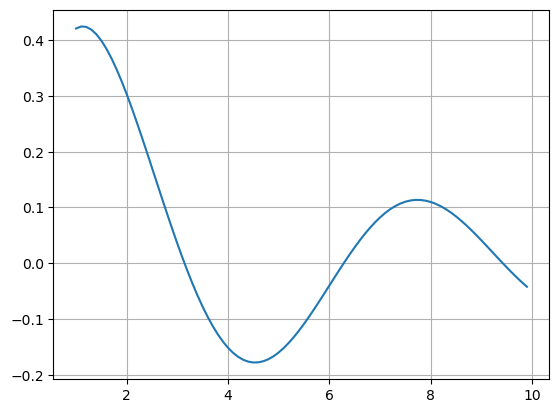

In [18]:
x = np.arange(1, 10, 0.1)
y = fun(x)
plt.plot(x, y) #function from matplotlib.pyplot used to plot a function
plt.grid()

#### Brent's method
We start with Brent's method. It does not need the derivative of $f$, but it requires you to specify an interval, or *bracket*, where the function has opposite signs. Mathematically, this means that if we set `bracket = [a,b]` in the description below, it must be that either $f(a) < 0$ and $f(b) > 0$, or $f(a) > 0$ and $f(b) < 0$.


For Brent's method, the two examples below illustrate that the root you find depends on the bracket. Note that the first input argument of the `optimize.root_scalar` function, is itself a function. It is important to realize that functions themselves can also be input arguments of other functions...

In [19]:
#First argument is function, second is the chosen method, third is the bracket (required for the chosen method)
result = optimize.root_scalar(fun, method='brentq', bracket=[2.0, 6.0])
print(result)

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 3.141592653589801


In [20]:
result = optimize.root_scalar(fun, method='brentq', bracket=[6.0, 8.0])
print(result)

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 6.283185307179586


If the opposite sign condition is not satisfied, Brent's methods returns a ValueError.

In [21]:
try:
    sol = optimize.root_scalar(fun, method='brentq', bracket=[1,2])
except ValueError as e:
     print(e)

f(a) and f(b) must have different signs


#### Newton's method
Newton's method needs both the function $f(x)$ and its derivative $f'(x)$ as input. The derivative is given to the argument `fprime`. The method also needs an initial estimate (instead of the bracket) for the root. This guess is entered into the argument `x0`.

In [23]:
result = optimize.root_scalar(
    fun,
    method='newton',
    fprime=f_deriv,
    x0=2.0,
)
print(result)

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 5
           root: 3.141592653589793


In [24]:
result = optimize.root_scalar(
    fun,
    method='newton',
    fprime=f_deriv,
    x0=5.0,
)
print(result)

      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 6
           root: 6.283185307179586


### Specifying additional function arguments <a name="additional"></a>
Sometimes a function has multiple input arguments, whereas the (scalar) optimization only happens with respect to one of these variables. For example, we might have the function

$$
g(x,a,b) = \frac{\sin(a\cdot x + b)}{x+1}
$$

but only want to minimize with respect to $x$ for fixed values of $a$ and $b$. For now, let's take $a = 1$ and $b = 0$. In many functions from `numpy` and `scipy`, one can fix additional arguments by giving the desired (minimization) function some extra arguments, that will automatically be passed on to its first input argument. 

In [25]:
def g(x,a,b):
    return np.sin(a*x + b)/(x+1)

In [26]:
try:
    result = optimize.root_scalar(g, method='brentq', bracket=[2.0, 6.0])
except TypeError as e:
    print(e)

g() missing 2 required positional arguments: 'a' and 'b'


The above code gives an error, as $g$ has three input arguments, whereas `optimize.root_scalar` can only optimize w.r.t. one of them. The additional arguments can be specified with the option `args = (a,b)` in this case (or more variables if the function $g$ would have had more).

In [27]:
#The correct way with a = 1 and b = 0
result = optimize.root_scalar(g, method='brentq', bracket=[2.0, 6.0], args = (1,0))
result

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 3.141592653589801

### Multidimensional functions <a name="root_multi"></a>

Suppose we want to solve a multidimensional non-linear system of equations, i.e.,

$$
\begin{align*}
f_1(x) &= 0 \\
f_2(x) &= 0 \\
&\vdots \\
f_m(x) &= 0
\end{align*}
$$

where $x \in \mathbb{R}^n$. We note that algorithms such as Brent's and Newton's method require $m = n$. In case $m \neq n$, one may use (non-linear) least squares algorithms, such as `optimize.least_squares`. Note that such methods find a solution even if a root does not exist. 

Below we give an example for the case $n = 1$ and $m = 3$ with

$$
\begin{align*}
f(x) &= \frac{\sin(x)}{x+1} = 0\\
g(x) &= (x - \pi)^2 = 0\\
h(x) &= (x - \pi) = 0,
\end{align*}
$$

which clearly has the solution $x = \pi$.

In [28]:
def f(x):
    return np.sin(x[0]) / (x[0]+1)

def g(x):
    return (x[0]-np.pi)**2

def h(x):
    return (x[0]-np.pi)

def system(x):
    return np.array([f(x),g(x),h(x)]) #We make explicit that the function argument for f,g and h is a scalar.

#Alternatively use the function below, that makes sure the function returns an array of shape (3,).
#Such an array is needed as input for optimize.least_squares() below

#def system(x):
#    return np.array([f(x),g(x),h(x)]).reshape(3,)

In [29]:
z = optimize.least_squares(system,0)
print(z)

 active_mask: array([0.])
        cost: 4.371766366198904e-34
         fun: array([2.95694652e-17, 0.00000000e+00, 0.00000000e+00])
        grad: array([-7.13963621e-18])
         jac: array([[-2.41453004e-01],
       [ 4.68133785e-08],
       [ 1.00000000e+00]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 8
        njev: 8
  optimality: 7.139636211563387e-18
      status: 1
     success: True
           x: array([3.14159265])


The two most important outputs of `optimize.least_squares` are `x` and `fun`, which denote the found (least-squares) root and the function value at that point, respectively. 

In [30]:
print(optimize.least_squares(system,0).x, optimize.least_squares(system,0).fun)

[3.14159265] [2.95694652e-17 0.00000000e+00 0.00000000e+00]


If `fun` equals (up to desired precision) the all-zeros vector, then we may conclude that the point found is indeed a root of the non-linear system.

In [31]:
check = np.allclose(z.fun,[0,0,0],atol=1e-16) #Check if function value is (approximately) equal to all-zeros vector
print(check)

True


We next slightly perturb the function $g(x)$ so that the system no longer has a solution. The method now finds a least-squares solution.

In [32]:
def f(x):
    return np.sin(x) / (x+1)

def h(x):
    return (x-np.pi)

def noisy_g(x):
    return (x-np.pi+0.1)**2

def noisy_system(x):
    return np.array([f(x[0]),noisy_g(x[0]),h(x[0])]) 

In [33]:
z = optimize.least_squares(noisy_system,0)
print(z.x, z.fun) #Gives least squares solution

[3.13980263] [ 0.00043239  0.0096452  -0.00179003]


In [34]:
check = np.allclose(z.fun,[0,0,0],atol=1e-16) #Check if function value is (approximately) equal to all-zeros vector
print(check)

False


## Optimization <a name='Optimization'></a>

### Optimization of scalar functions

The `minimize_scalar` function can be used to minimize a scalar function. For instance, let's numerically try to minimize the quadratic function

$$f(x) = (x-3)^2 + 2x - 3.$$

In [37]:
def quadratic_fun(x):
    return (x - 3)**2 + 2*x  - 3

In [39]:
result = optimize.minimize_scalar(quadratic_fun)
print('Result summary:')
print(result)

x_min = result.x
y_min = result.fun  # equivalent to quadratic_fun(x_min)

Result summary:
     fun: 2.0
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 9
     nit: 4
 success: True
       x: 2.0


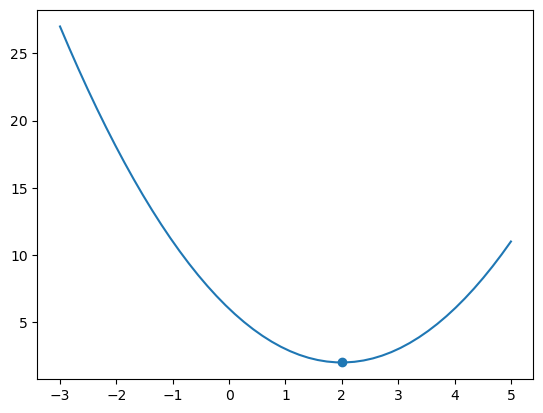

In [42]:
x = np.linspace(-3, 5)
y = quadratic_fun(x)
plt.plot(x, y)
plt.scatter(x_min, y_min)

Also here it is possible to specify additional arguments, in the function we want to optimize over has multiple input arguments. Consider

$$
g(x,a) = (x-3)^2 + a \cdot x - 3.
$$

and suppose we want to minimize the this function for $x$ for $a = 2$. 

In [43]:
def quadratic_fun2(x,a):
    return (x - 3)**2 + a*x  - 3

In [44]:
result = optimize.minimize_scalar(quadratic_fun2, args=(2))
print('Result summary:')
print(result) #Should give the same output as for quadratic_fun

Result summary:
     fun: 2.0
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 9
     nit: 4
 success: True
       x: 2.0


### Optimization of multivariate functions

#### Unconstrained optimization

Consider the following **unconstrained** minimization problem:

$$\min_{x\in\mathbb{R}^n} E(x) =  \left(\Vert P(x-c) \Vert_2\right)^2 = (x-c)^T P^T P (x-c)$$

where $c\in\mathbb{R}^n$ and $P\in\mathbb{R}^{n \times n}$. (The objective is the Euclidean norm squared.) 

The objective is minimized for $x=c$, since then $\Vert P(x-c)\Vert_2 = 0$ and $E(x)$ is always nonnegative, but let's see whether we can solve this problem numerically using Scipy. For $n=2$, we are (roughly speaking) trying to find the center of an ellipse as illustrated below.

In [50]:
def ellipse(x, P, c):
    """Compute weighted distance ||P(x-c)|| from point to center of ellipse.
    
    Input argument `x`, which is an ndarray, can also be two-dimensional array with points in rows. 
    In this case the weighted distance is compute for every row (i.e., point).
    """
    
    # If x has multiple dimensions, then assume points are in rows of x (hence we need to tranpose)
    return np.sum((P @ (x - c).T) * (P @ (x - c).T), axis=0)

In [51]:
P = np.array([
    [3, 1], 
    [1 ,2],
])
center = np.array([-2, -1])
x = np.array([[1,2],[3,4],[-2,-1]])

print(ellipse(x,P,center)) #Note that for the center [-2,-1], the function value indeed is zero.

[225 625   0]


For $n = 2$, we can visualize $E(x)$ using a contour plot to give you some intuition. Let's do this first.

We define a grid $[-5,5] \times [-5,5]$ using `np.mgrid` with precision $0.1$. In order to evaluate the `ellipse` function on every grid point, we first have to create a two-dimensional array whose rows corresponds to the grid points (the array `x`; see Lecture 1 for the methods used here). Finally, we evaluate `ellipse` in all the grid points, and transform the output back into matrix shape (the array `y`).

In [52]:
# Evaluate on xy-grid 
x1, x2 = np.mgrid[-5:5:0.1, -5:5:0.1]
x = np.vstack((x1.ravel(), x2.ravel())).T #Gives array with all the grid points as rows.
y = ellipse(x, P, center).reshape(x1.shape)

Now that we have evaluted the ellipse on all the grid points, we can plot them using `plt.contourf`. It takes as input arguments `x1`, `x2` and the function evaluations on the grid the form, the array `y`. The argument `70` indicates the precision of the plot (you can vary this yourself), i.e., how many contours we want to see. The argument `cmap` defines the color map.

In [53]:
#Visualize
plt.contourf(x1, x2, y, 70, cmap='coolwarm') #Plot the contours
plt.colorbar() #Plot the colorbar on the right
plt.scatter(center[0],center[1],color='black') #Plots the center point
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contours of the "ellipse"" E(x)')

Text(0.5, 1.0, 'Contours of the "ellipse"" E(x)')

Now let's try to solve the problem *numerically* using Scipy's `minimize` function from the `scipy.optimize` module. 

Unlike it's one-dimensional counterpart `scipy.optimize_scalar`, we also need to input an initial guess. Also note that, just as for specifying additional arguments in the case of scalar minimization, here we also specify the additional arguments of `ellipse`, namely $P$ and $c$, in `optimize.minimize`. The optimization happens w.r.t. the first argument of `ellipse`, which is $x$.

In [54]:
x_init = [0.0, 0.0]
# Note that `args` are additional arguments needed for evaluating `ellipse`.
result = optimize.minimize(ellipse, x_init, args=(P, center))
result

      fun: 5.551140600322028e-16
 hess_inv: array([[ 0.1, -0.1],
       [-0.1,  0.2]])
      jac: array([-3.41948692e-13, -2.35367281e-13])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([-2.00000001, -1.        ])

In [55]:
# Extract minimum location.
x_min = result.x
y_min = ellipse(x_min, P, center)

print('Minimum location is:',x_min)
print('The function value at the minimum is 0?', np.allclose(y_min,0))

Minimum location is: [-2.00000001 -1.        ]
The function value at the minimum is 0? True


#### Constrained optimization

Now we make things a bit more difficult considering a **constrained** problem:

$$
\begin{align*}
\min_{x\in\mathbb{R}^n} & \ \ \ E(x) =  \left(\Vert P(x-c) \Vert_2\right)^2 = (x-c)^T P^T P (x-c)\\
\text{s.t. } & \sum_{i=1}^n x_i = 1 \\
& x_i \geq 0 \qquad \forall i = 1,\dots,n
\end{align*}
$$

Linear (in)equalities can be modelled using `optimize.LinearConstraint`. The syntax is that you can model one or more constraints 

$$
l \leq a^T x \leq u
$$

were $a \in \mathbb{R}^n$ and $l, u \in \mathbb{R}$ with $l \leq u$. For the above example, we should set $a = [1,1]$, $l = 1$ and $u = 1$ in case $n = 2$. (Note that choosing $l = u$ allows you to model equality constraints.) The arguments used for $a$, $l$ and $u$ are `A`, `lb`, and `ub`, respectively.

In [56]:
sum_is_one= optimize.LinearConstraint(
    A=[1, 1],
    lb=1,
    ub=1,
)

In `optimize.minimize`, we specify the following:
- The function to be optimized; `ellipse` here.
- An initial guess; `x_init` here.
- Additional arguments for the function that is to be optimized; `args=(P,c)` here for the function `ellipse`.
- Upper and lower bounds on the variables over which we optimize. 
    - Here model $0 \leq x_1,x_2 \leq \infty$ through `bounds=((0.0, np.inf), (0.0, np.inf))`.
- The additional linear constraints in the argument `constraints`; `sum_is_one` here.

In [57]:
result = optimize.minimize(
    ellipse,
    x_init,
    args=(P, center),
    bounds=((0.0, np.inf), (0.0, np.inf)),
    constraints=sum_is_one
)
result

     fun: 100.00000000005828
     jac: array([60., 40.])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0., 1.])

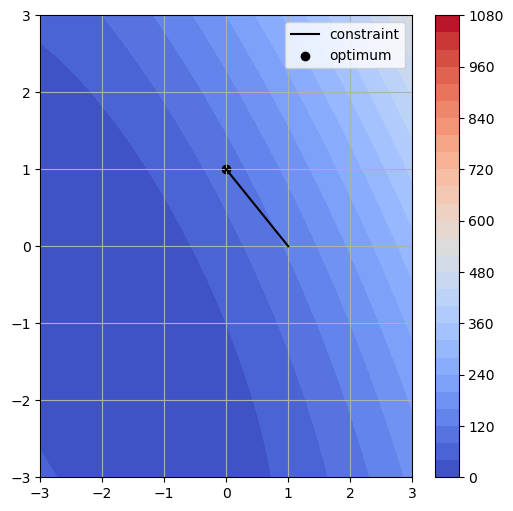

In [58]:
x_min = result.x
y_min = ellipse(x_min, P, center)

plt.figure(figsize=(6, 6))
plt.contourf(x1, x2, y, 30,cmap='coolwarm')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.colorbar()
plt.plot([1,0], [0, 1], color='black', label='constraint')
plt.scatter(x_min[0], x_min[1], label='optimum',color='black')
plt.legend()
plt.grid()

In case we have multiple constraints, we can enter the appropriate multi-dimensional arrays. The code below models the constraints

$$\left\{\begin{eqnarray}
x_1 & + & x_2 & =  & 1 \\
2x_1 & + & 4x_2 & \leq & 2
\end{eqnarray}\right.$$

Note that one can also use, e.g., `np.inf` to model that there is no upper or lower bound for a given constraint. You should read the second constraint as 

$$-\infty \leq 2x_1 + 4x_2 \leq 2.$$

In [59]:
linear_constraints= optimize.LinearConstraint(
    A=[[1, 1],[2,4]],
    lb=[1,-np.inf],
    ub=[1,2],
)

In [60]:
result = optimize.minimize(
    ellipse,
    x_init,
    args=(P, center),
    bounds=((0.0, np.inf), (0.0, np.inf)),
    constraints=linear_constraints
)
result

C:\Users\pskleer\Anaconda3\lib\site-packages\scipy\optimize\_constraints.py:524: OptimizeWarning: Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 
  warn("Equality and inequality constraints are specified in the same "


     fun: 125.0000000000291
     jac: array([70., 40.])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1., 0.])

### Other Optimization Libraries

The `scipy.optimization` module also contains a `linprog` method for solving *linear optimization* (also known as linear programming (LP)) problems. It's okay to use this algorithm for small problems, but for large scale, integer, or convex optimization problems it is better to use state-of-the-art solvers such as [CPLEX](https://www.ibm.com/analytics/cplex-optimizer), [GUROBI](https://www.gurobi.com/), or [MOSEK](https://www.mosek.com/). These solvers are free for *academic* use and also offer Python interfaces to the solvers. [Glpk](https://www.gnu.org/software/glpk/) and [CVXOPT](https://cvxopt.org/) are good non-commercial alternatives if the academic licenses are not applicable.

[Picos](https://pypi.org/project/PICOS/) and [PuLP](https://pypi.org/project/PuLP/) are two optimization modeling libaries, which offer a generic modeling method to declare your optimization problems independently of the solver you want to use later on.

## Statistics <a name="statistics"></a>

In [61]:
import scipy.stats as stats

The `scipy.statistics` module offers many methods for computing all kinds of statistics. In addition, it contains a nice class-based interface to many discrete and continous probability distributions. Below we give a short illustration of the possibilities. Please refer to the official documentation for all options.

All continuous distributions share a common parent class. This has the big advantage that these distributions share some common methods, for instance, the method `pdf` can be used to evaluate the probability density function. The main public methods for continuous RVs are:
- rvs: Random Variates
- pdf: Probability Density Function
- cdf: Cumulative Distribution Function
- sf: Survival Function (1-CDF)
- ppf: Percent Point Function (Inverse of CDF)
- isf: Inverse Survival Function (Inverse of SF)
- stats: Return mean, variance, (Fisher’s) skew, or (Fisher’s) kurtosis
- support: Return the support of the distribution
- moment: non-central moments of the distribution

These public methods are very convenient to implement functions for unspecified probability distributions as the following examples illustrate.

In [64]:
def finite_support(dist, alpha=0.001):
    """Return a finite support for distribution.
    
    Arguments
    ---------
    dist : stats.rv_continuous
        A continuous distribution.
    alpha : float, optional
        Quantile to use as replacement for infinite boundary (default 0.001).
    
    Returns
    -------
    lower : float
        Lower bound (or quantile) of support.
    upper : float
        Upper bound (or quantile) of support.
    
    If the actual support is not finite, then return a finite quantile instead.
    """
    lower, upper = dist.support()
    if np.isinf(lower):
        lower = dist.ppf(alpha)
    if np.isinf(upper):
        upper = dist.isf(alpha)
    return lower, upper


def visualize_distribution(dist, ax):
    """Visualize pdf, and mean/median location of distribution.
    
    Arguments
    ---------
    dist : stats.rv_continous
        A continuous distribution.
    ax : axes
        Matplotlib axes where to plot.
    """
    # pdf between two quantiles.
    lower, upper = finite_support(dist)
    x = np.linspace(lower, upper)
    y = dist.pdf(x)
    ax.plot(x, y, label='pdf')

    # Vertical line at mean.
    mean = dist.stats('m')
    ax.axvline(mean, color='red', label='mean', alpha=0.5)

    # Vertical line at median.
    median = dist.median()
    ax.axvline(median, linestyle='--', color='green', label='median', alpha=0.7)

    # Axis settings
    ax.set_ylabel('density')
    ax.set_ylim(bottom=0)
    ax.grid()
    ax.legend()

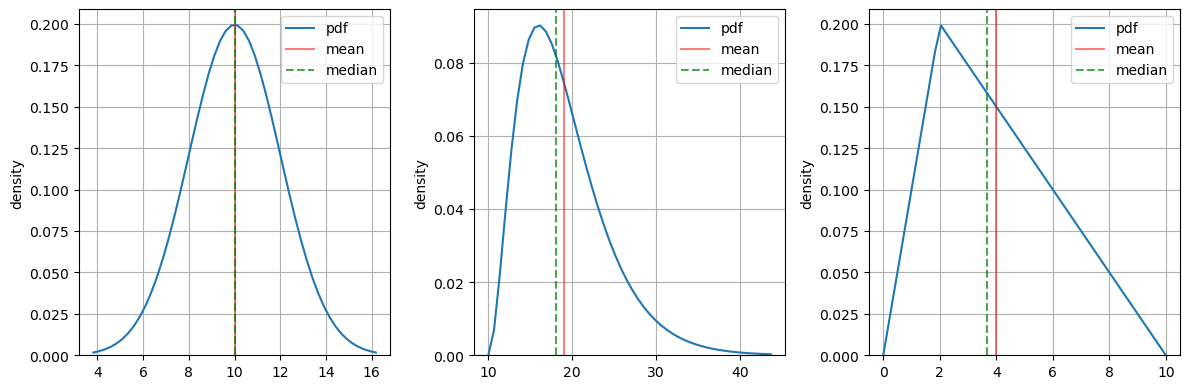

In [65]:
# An arbitrary list of continuous distributions.
sample_distributions = [
    stats.norm(loc=10, scale=2),
    stats.gamma(3, loc=10, scale=3),
    stats.triang(0.2, loc=0, scale=10)
]

# Visualize for list of distributions.
fig, axes = plt.subplots(1, len(sample_distributions), figsize=(12, 4))
for ax, dist in zip(axes, sample_distributions):
    visualize_distribution(dist, ax=ax)
plt.tight_layout()

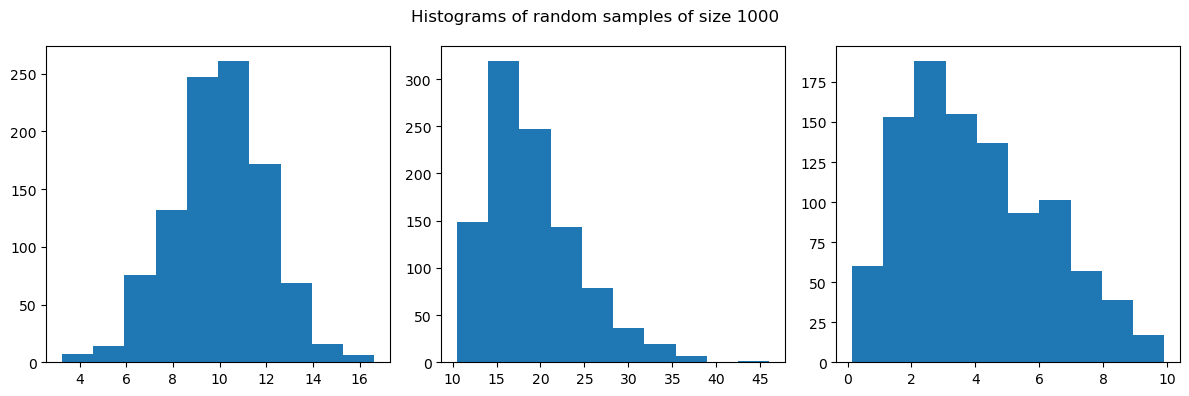

In [66]:
# Histograms of random samples.
n = 1000
fig, axes = plt.subplots(1, len(sample_distributions), figsize=(12, 4))
for ax, dist in zip(axes, sample_distributions):
    x = dist.rvs(n)
    ax.hist(x)
plt.suptitle(f'Histograms of random samples of size {n}')
plt.tight_layout()

## Data fitting <a name="datafitting"></a>
In this section, we will discuss some well-known methods for fitting the parameters of a given function according to given data.

### Linear regression <a name="linearregression"></a>
Perhaps the simplest example of data fitting is linear regression, where the goal is to fit given data points $(x_1,y_1),\dots,(x_n,y_n)$ according to a linear function 

$$y = a \cdot x + b.$$ 

That is, the goal is to determine the coefficients $a$ and $b$ that best fit the data. This can be done with the `linregress` from the `scipy.stats` package. The function `linregress` produces various outputs, of which the first two are the slope $a$ and so-called intercept $b$.

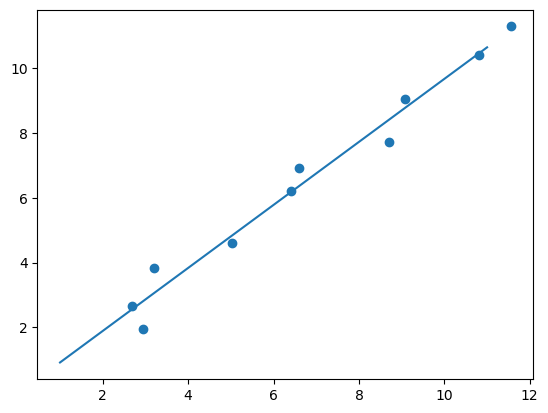

In [77]:
#We generate the point (1,1), (2,2), (3,3) etc.. but with some random noise added to them.
x = np.arange(1,11) + 2*np.random.rand(10)
y = np.arange(1,11) + 2*np.random.rand(10)

a, b, *_ = stats.linregress(x,y) #We suppres all the remaining outputs

plt.scatter(x,y)
w = np.linspace(1,11)
z = a*w + b
plt.plot(w,z)

### Non-linear (least-squares) regression<a name="nonlinearregression"></a>

Non-linear least squares problem occur often with curve fitting problems. The `scipy.optimization` module has several functions that can be used for this type of problems. Here we show the `curve_fit` and `least_squares` functions.

Here we will consider the underlying model

$$y = \left( \frac{a + \sqrt{x}}{b \sqrt{x}} \right)^2 + \varepsilon.$$

and the goal is to find the values of $a$ and $b$ that best fit the given data $(x_1,y_1),\dots,(x_n,y_n)$.

In [68]:
#Observations
x = np.array([0.5, 1, 2, 3, 4])
y = np.array([11.1, 6.3, 3.7, 2.7, 2.3])

plt.scatter(x, y)
plt.title("Observed data");

In [69]:
def model(x, a, b):
    """Evaluate model.
    
    Arguments
    ---------
        x : array
            Values at which to evaluate the model.
        a, b : float
            Model parameter.
    """
    return ((a + np.sqrt(x)) / (b * np.sqrt(x))) ** 2

#### curve_fit
We start by estimating the unknown parameters $a$ and $b$ using the `curve_fit` method. It is important to carefully analyze method's signature to check the order of arguments and optional arguments. These methods in Scipy can also be provided with derivative information (not shown here), which can be exploited by the underlying algorithm.

In [70]:
ab_init = [1.0, 1.0]
result = optimize.curve_fit(model, x, y, ab_init)

#Estimated parameters are in first output argument of optimize.curve_fit
fitted_parameters = result[0]
ahat = fitted_parameters[0]
bhat = fitted_parameters[1]

print('Estimated parameters (obtained with `curve_fit`):')
print('ahat = %.6f' % (ahat))
print('bhat = %.6f' % (bhat))

Estimated parameters (obtained with `curve_fit`):
ahat = 3.935215
bhat = 1.969802


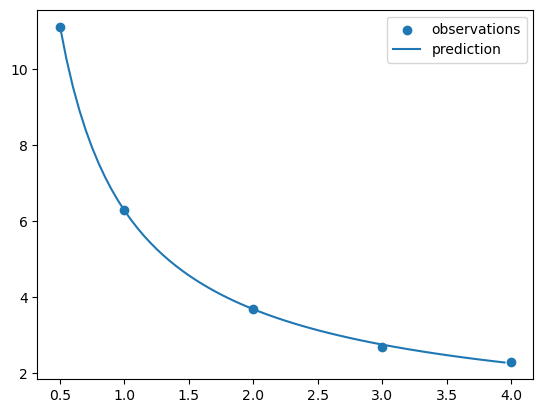

In [71]:
# Visualize estimated model.
xi = np.arange(0.5, 4, 0.05)
yi = model(xi, ahat, bhat)

plt.scatter(x, y, label='observations')
plt.plot(xi, yi, label='prediction')
plt.legend();

#### least_squares
We can also use the `least_squares` function (that we saw before) to estimate the parameters, but this works slightly different. The idea is now, that, in order to fit the model, we want to find a least-squares solution $(a,b)$ such that

$$y_i - \left( \frac{a + \sqrt{x_i}}{b \sqrt{x_i}} \right)^2 = 0.$$

for all $i = 1,\dots,n$. 

We therefore first define a function that returns an array of resulting errors 

$$y_i - \left( \frac{a + \sqrt{x_i}}{b \sqrt{x_i}} \right)^2.$$

The first argument `pars` is an array containing all unknown parameters (which are $a$ and $b$ for us). We can use the previously defined `model` function to compute this error function as follows.

In [72]:
def error(pars, x, y):
    """Compute error vector for given parameters and observations."""
    # *pars unpacks all entries in this array/list.
    return y - model(x, *pars)

Next, we perform the least-squares method on the `error` function, using an initial estimate `ab_init` for $[a,b]$, and where `args=(x,y)` are the additional arguments for `error`, the data points $(x_1,y_1),\dots,(x_n,y_n)$ in our case.

In [73]:
result = optimize.least_squares(error, ab_init, args=(x, y))
print(result)

# Extract the two parameter estimates.
ahat2, bhat2 = result.x
print('\nEstimates obtained with `least_squares`:')
print(f'\tahat = {ahat2:.6f}') #Alternative way of printing results compared to curve_fit example
print(f'\tbhat = {bhat2:.6f}')

 active_mask: array([0., 0.])
        cost: 0.002583565459899015
         fun: array([-0.00849561,  0.02278614,  0.01243607, -0.0591841 ,  0.03030402])
        grad: array([-7.44632009e-10, -3.66098304e-09])
         jac: array([[-4.78574991, 11.27879254],
       [-2.54384616,  6.37344561],
       [-1.37867581,  3.74409552],
       [-0.9737267 ,  2.80148334],
       [-0.7648235 ,  2.30449117]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 7
        njev: 7
  optimality: 3.6609830444955804e-09
      status: 1
     success: True
           x: array([3.9352151 , 1.96980222])

Estimates obtained with `least_squares`:
	ahat = 3.935215
	bhat = 1.969802


## Interpolation

The `scipy.interpolate` module contains some functions that can be used to interpolate both 1-D as multi-dimensional data. The interpolation functions usually offer different options yielding various smooth and non-smooth interpolation methods.

Let's look at a simple 1-D example where we interpolate some observations from the sine function. The `interp1d` class from the interpolation module returns an object that can be called as the resulting interpolation function as illustrated by the following example.

In [74]:
import scipy.interpolate as interpolate

In [75]:
x = np.array([0, 1, 3, 5, 6, 8, 10])
y = np.sin(x)
xi = np.linspace(0, 10)

plt.plot(xi, np.sin(xi), label='sine')
plt.scatter(x, y, label='data')
plt.title('Some observations from sine function')
plt.legend();

In [76]:
# Interpolation methods.
methods = [
    'linear',
    'nearest',
    'quadratic',
    'cubic',
]

# Prepare subplots.
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for method, ax in zip(methods, axes.ravel()):
    # Plot data and sine function.
    ax.scatter(x, y)
    ax.plot(xi, np.sin(xi))

    # 1-D interpolation
    fun = interpolate.interp1d(x, y, kind=method)
    # Plot interpolation function.
    ax.plot(xi, fun(xi))
    ax.set_title(f'{method} interpolation')

plt.tight_layout()